In [82]:
import gym
import matplotlib.pyplot as plt
from gym import ObservationWrapper
import cv2
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
from gym.spaces import Box
import collections


In [83]:
class GrayscaleObservation(ObservationWrapper):
    def __init__(self, env):
        super(GrayscaleObservation, self).__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0.0, high=1.0, shape=(obs_shape[0], obs_shape[1], 1), dtype=np.float32)

    def observation(self, obs):
        if obs.shape[-1] == 3:
            gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        else:
            gray = obs 
        gray = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        gray = gray.astype(np.float32)
        return np.expand_dims(gray / 255.0, axis=-1)

class FireResetWrapper(gym.Wrapper):
    def __init__(self, env):
        super(FireResetWrapper, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE', "Environment does not support FIRE action!"
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs) 
        obs, _, terminated, truncated, info = self.env.step(1)
        if terminated or truncated:
            obs, info = self.env.reset(**kwargs)

        return obs, info

class FrameStackRepeatAction(ObservationWrapper):
    def __init__(self, env, n_frames):
        super(FrameStackRepeatAction, self).__init__(env)
        self.n_frames = n_frames
        self.observation_space = Box(
            low=0.0, high=1.0, 
            shape=(n_frames, *env.observation_space.shape[:2]), 
            dtype=np.float32
        )
        self.frame_buffer = collections.deque(maxlen=n_frames)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.n_frames):
            self.frame_buffer.append(obs)
        return self._get_stacked_frames(), info

    def step(self, action):
        total_reward = 0.0
        done = False
        info = {}

        for _ in range(self.n_frames):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self.frame_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                done = True
                break
        
        return self._get_stacked_frames(), total_reward, done, info

    def _get_stacked_frames(self):
        return np.stack(self.frame_buffer, axis=0)

In [84]:
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
env = FireResetWrapper(env) 
env = GrayscaleObservation(env)
env = FrameStackRepeatAction(env, n_frames=4)

obs, info = env.reset()

TypeError: Invalid shape (4, 84, 84) for image data

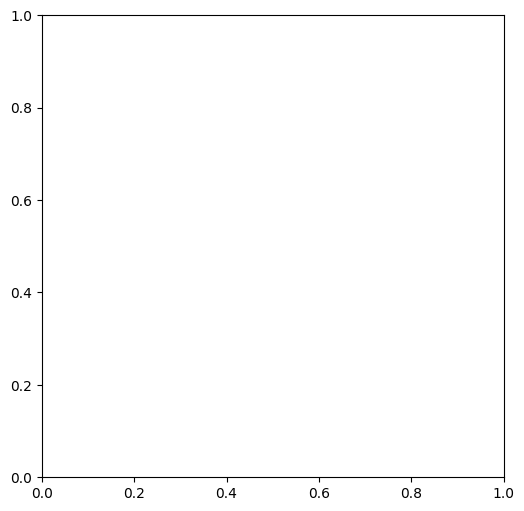

In [81]:
plt.figure(figsize=(6,6))
plt.imshow(obs.squeeze(), cmap="gray", vmin=0, vmax=1) 
plt.axis('off')
plt.show()

In [ ]:
for i in range(20):
    obs, _, _, _, _ = env.step(3)

ResetNeeded: Cannot call env.step() before calling env.reset()

In [86]:
env.observation_space.shape

(4, 210, 160)